In [1]:
import math
import torch
import gpytorch
import pyro
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
train_x = torch.linspace(0, 1, 100)
train_y = torch.sign(torch.cos(train_x * (4 * math.pi)))
#train_y[train_y == -1] = 0

In [3]:
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.models import PyroVariationalGP

class PyroGPClassificationModel(PyroVariationalGP):
    def __init__(self, likelihood, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution)
        super(PyroGPClassificationModel, self).__init__(variational_strategy, likelihood, name_prefix="basic_gp_test")
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x).add_jitter(1e-2)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

# Initialize model and likelihood
likelihood = gpytorch.likelihoods.BernoulliLikelihood()
model = PyroGPClassificationModel(likelihood, train_x)

In [4]:
from pyro import optim
from pyro import infer

optimizer = optim.Adam({"lr": 0.1})

elbo = infer.Trace_ELBO(num_particles=200, vectorize_particles=True)
svi = infer.SVI(model.model, model.guide, optimizer, elbo)

In [12]:
num_epochs = 200

for i in range(num_epochs):
        loss = svi.step(train_x, train_y)
        print('Iteration {}, Loss = {}'.format(i, loss))

Iteration 0, Loss = -435.6126318359375
Iteration 1, Loss = -460.4348583984375
Iteration 2, Loss = -470.08318359375
Iteration 3, Loss = -474.8051611328125
Iteration 4, Loss = -487.5352783203125
Iteration 5, Loss = -503.1960693359375
Iteration 6, Loss = -498.6556787109375
Iteration 7, Loss = -516.727001953125
Iteration 8, Loss = -526.4109716796875
Iteration 9, Loss = -541.4094091796875
Iteration 10, Loss = -534.1502392578125
Iteration 11, Loss = -558.5402392578125
Iteration 12, Loss = -554.9213427734375
Iteration 13, Loss = -557.9631298828125
Iteration 14, Loss = -565.712548828125
Iteration 15, Loss = -578.84255859375
Iteration 16, Loss = -567.311953125
Iteration 17, Loss = -605.2130078125
Iteration 18, Loss = -595.8530322265625
Iteration 19, Loss = -602.2506591796875
Iteration 20, Loss = -617.2341162109375
Iteration 21, Loss = -608.32912109375
Iteration 22, Loss = -625.375771484375
Iteration 23, Loss = -640.04107421875
Iteration 24, Loss = -625.225771484375
Iteration 25, Loss = -638.664

In [13]:
model.eval()
test_x = torch.linspace(0, 1, 30)
pred_dist = model(test_x)

/mnt/c/Users/Gardn/linux/gpytorch/gpytorch/utils/sparse.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  device=sparse._values().device,


In [14]:
pred_y = likelihood(pred_dist)

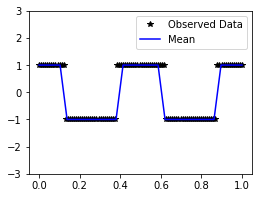

In [15]:
# Initialize fig and axes for plot
f, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
# Get the predicted labels (probabilites of belonging to the positive class)
# Transform these probabilities to be 0/1 labels
pred_labels = pred_y.mean.ge(0.5).float().mul(2).sub(1)
ax.plot(test_x.numpy(), pred_labels.numpy(), 'b')
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])